## Neural Nets Implementation & XOR Problem

**Goal:** The goal of this exercise is to implement a small neural network from scratch and train it using backprop.

In [11]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [12]:
# Load xor toy dataset
with open('xordata.pkl', 'rb') as f:
    data = pickle.load(f)

X_train = data['X_train'] # 800 training data points with 2 features
y_train = data['y_train'] # training binary labels {0,1}

X_test = data['X_test']
y_test = data['y_test']

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 2) (800,)
(200, 2) (200,)


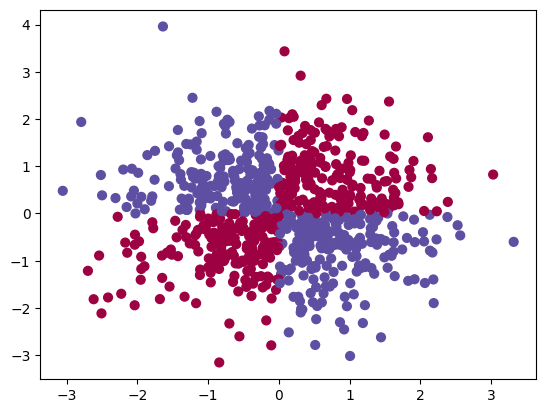

In [14]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)

**In this exercise, do the following:**
1. Implement brackprop to train a two-layer perceptron: an input layer, a hidden layer, and an output layer.
2. The core of the code should include: a forward pass, a backward pass, and weight updates.
3. For input and output layers specify the number of nodes appropriate for the above problem.
4. Randomly initialize the weights and biases of the network.
5. For the hidden layer use ReLU as an activation function and for the output layer use logistic sigmoid.
6. Use cross-entropy loss as the network's loss function and mini-batch SGD as the optimizer.
7. Use cross-validation to estimate performance.
8. Tune the network as you see fit (including number of units in the hidden layer, learning rate,  batch size, number of epochs, etc).
9. Provide a classification report of the performance on the train and test set.
10. Write a summary. Make sure you document your code well.
  
(Optional) You can use sklearn.inspection.DecisionBoundaryDisplay to visualize your decision boundary.

Starting 5-Fold Cross-Validation

Training fold 1...
Validation Accuracy for fold 1: 0.6250

Training fold 2...
Validation Accuracy for fold 2: 0.6562

Training fold 3...
Validation Accuracy for fold 3: 0.6312

Training fold 4...
Validation Accuracy for fold 4: 0.6562

Training fold 5...
Validation Accuracy for fold 5: 0.6062

Average Cross-Validation Accuracy: 0.6350

Training final model on the full training set...
Cost after epoch 0: 0.6931
Cost after epoch 100: 0.6909
Cost after epoch 200: 0.6567
Cost after epoch 300: 0.6351
Cost after epoch 400: 0.6320
Cost after epoch 500: 0.6309
Cost after epoch 600: 0.6307
Cost after epoch 700: 0.6306
Cost after epoch 800: 0.6306
Cost after epoch 900: 0.6305


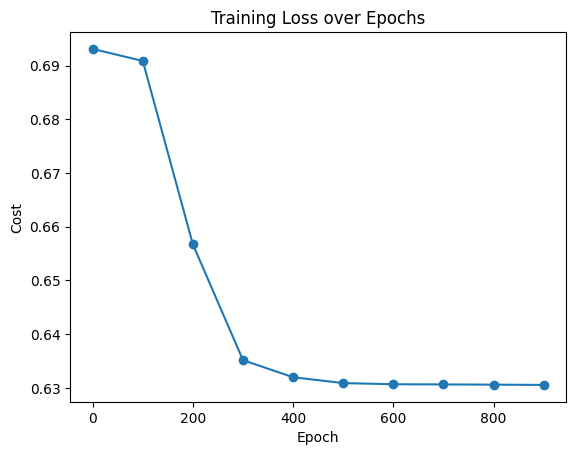


Training Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.38      0.50       387
           1       0.60      0.89      0.72       413

    accuracy                           0.64       800
   macro avg       0.68      0.63      0.61       800
weighted avg       0.68      0.64      0.62       800

Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.39      0.52        97
           1       0.61      0.89      0.72       103

    accuracy                           0.65       200
   macro avg       0.69      0.64      0.62       200
weighted avg       0.69      0.65      0.63       200



In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(42)
    W1 = np.random.randn(n_x, n_h) * 0.01
    b1 = np.zeros((1, n_h))
    W2 = np.random.randn(n_h, n_y) * 0.01
    b2 = np.zeros((1, n_y))
    return W1, b1, W2, b2

def forward_propagation(X, W1, b1, W2, b2):
    # Hidden layer computations
    Z1 = np.dot(X, W1) + b1      # Linear step for hidden layer
    A1 = relu(Z1)                # Activation using ReLU
    
    # Output layer computations
    Z2 = np.dot(A1, W2) + b2      # Linear step for output layer
    A2 = sigmoid(Z2)             # Activation using sigmoid for binary classification
    
    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

def compute_cost(A2, Y):
    m = Y.shape[0]
    # Adding epsilon (1e-8) to avoid log(0)
    cost = -np.sum(Y * np.log(A2 + 1e-8) + (1 - Y) * np.log(1 - A2 + 1e-8)) / m
    return cost

def backward_propagation(X, Y, cache, W2):
    m = X.shape[0]
    A1 = cache["A1"]
    A2 = cache["A2"]
    Z1 = cache["Z1"]
    
    # Gradient for output layer (using cross-entropy loss with sigmoid output)
    dZ2 = A2 - Y                   # Shape: (m, 1)
    dW2 = np.dot(A1.T, dZ2) / m     # Shape: (n_h, 1)
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m
    
    # Backpropagate to hidden layer
    dA1 = np.dot(dZ2, W2.T)         # Shape: (m, n_h)
    dZ1 = dA1 * relu_derivative(Z1) # Element-wise multiplication
    dW1 = np.dot(X.T, dZ1) / m      # Shape: (n_x, n_h)
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m
    
    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients

def update_parameters(W1, b1, W2, b2, grads, learning_rate):
    W1 -= learning_rate * grads["dW1"]
    b1 -= learning_rate * grads["db1"]
    W2 -= learning_rate * grads["dW2"]
    b2 -= learning_rate * grads["db2"]
    return W1, b1, W2, b2

def train(X, Y, n_h, learning_rate, epochs, batch_size, print_cost=True):
    n_x = X.shape[1]
    n_y = 1
    W1, b1, W2, b2 = initialize_parameters(n_x, n_h, n_y)
    costs = []
    m = X.shape[0]
    
    for epoch in range(epochs):
        # Shuffle the training data
        permutation = np.random.permutation(m)
        X_shuffled = X[permutation]
        Y_shuffled = Y[permutation]
        
        # Mini-batch gradient descent
        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            Y_batch = Y_shuffled[i:i+batch_size]
            
            # Forward pass
            A2, cache = forward_propagation(X_batch, W1, b1, W2, b2)
            # Compute cost
            cost = compute_cost(A2, Y_batch)
            # Backward pass
            grads = backward_propagation(X_batch, Y_batch, cache, W2)
            # Update parameters
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, grads, learning_rate)
        
        # Optionally record and print the cost on the entire training set every 100 epochs
        if print_cost and epoch % 100 == 0:
            A2_full, _ = forward_propagation(X, W1, b1, W2, b2)
            full_cost = compute_cost(A2_full, Y)
            costs.append(full_cost)
            print(f"Cost after epoch {epoch}: {full_cost:.4f}")
    
    return W1, b1, W2, b2, costs

def predict(X, W1, b1, W2, b2):
    A2, _ = forward_propagation(X, W1, b1, W2, b2)
    predictions = (A2 > 0.5).astype(int)
    return predictions

# Ensure labels are column vectors for the computations
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print("Starting 5-Fold Cross-Validation")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []
fold = 1

# Hyperparameters
n_h = 5           # number of hidden units
learning_rate = 0.01
epochs = 1000
batch_size = 32

for train_index, val_index in kf.split(X_train):
    X_cv_train, X_cv_val = X_train[train_index], X_train[val_index]
    y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]
    
    print(f"\nTraining fold {fold}...")
    W1, b1, W2, b2, _ = train(X_cv_train, y_cv_train, n_h, learning_rate, epochs, batch_size, print_cost=False)
    preds = predict(X_cv_val, W1, b1, W2, b2)
    acc = np.mean(preds.reshape(-1) == y_cv_val.reshape(-1))
    print(f"Validation Accuracy for fold {fold}: {acc:.4f}")
    cv_accuracies.append(acc)
    fold += 1

print("\nAverage Cross-Validation Accuracy: {:.4f}".format(np.mean(cv_accuracies)))
print("\nTraining final model on the full training set")
W1, b1, W2, b2, costs = train(X_train, y_train, n_h, learning_rate, epochs, batch_size, print_cost=True)

# Plot training cost over epochs
plt.plot(np.arange(0, epochs, 100), costs, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("Training Loss over Epochs")
plt.show()

# Predictions on train and test set
train_preds = predict(X_train, W1, b1, W2, b2)
test_preds = predict(X_test, W1, b1, W2, b2)

print("\nTraining Classification Report:")
print(classification_report(y_train, train_preds))
print("Test Classification Report:")
print(classification_report(y_test, test_preds))